<a href="https://colab.research.google.com/github/aminejarraya/Deep-Learning-Image-Compression-/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Necessary Packages

In [ ]:
#Install open slide Package
!apt update && apt install -y openslide-tools
!pip install openslide-python

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:13 https://developer.

In [ ]:
#Packages to Unzip rar file
!pip install pyunpack
!pip install patool

## Import packages

In [ ]:
import cv2
from google.colab import drive
import numpy as np
import tensorflow
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from pyunpack import Archive
import openslide
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

In [ ]:
#Mount Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Extract zip file located in the drive into home
Archive('/content/drive/MyDrive/TCGA-A8-A08F-01A-01-TS1.e2b24767-1df7-431b-bba2-45d1b4e767d8.rar').extractall('./')

## Read collected Data

In [ ]:
#Collected data have BGRA format we converted to RGB
def convert(image):
  np_image = np.array(image)
  bgrtorgb = cv2.cvtColor(np_image, cv2.COLOR_BGRA2RGB)
  return bgrtorgb

In [ ]:
#ImageDataGenerator to augment our Data
train_image_generator = ImageDataGenerator(preprocessing_function=convert, horizontal_flip=True, zoom_range=0.05, rescale=1.0/255.0) 
validation_image_generator = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
#Training samples
train_data_gen = train_image_generator.flow_from_directory(directory = "/content/drive/MyDrive/Traine", #directory which contains images
                                                           batch_size=1, #each step contains 1 sample
                                                           shuffle=True, #images will be putted randomly
                                                           target_size=(256, 256),#input images will have the size of 256x256
                                                           class_mode='input'#Due to unsupervised autoencoder learning
                                                          )

In [ ]:
#Test samples
val_data_gen = validation_image_generator.flow_from_directory(directory = "/content/drive/MyDrive/Vale",
                                                           batch_size=1, 
                                                           shuffle=True,
                                                           target_size=(256, 256),
                                                           class_mode='input'
                                                          )

#Plot augmented images 

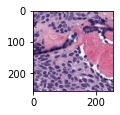

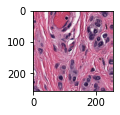

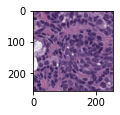

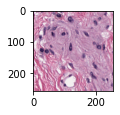

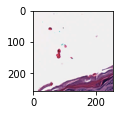

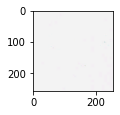

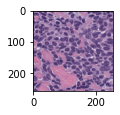

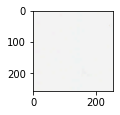

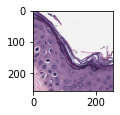

In [ ]:
for i in range(9):
  pyplot.figure(figsize=(5,5))
	# define subplot
  pyplot.subplot(330 + 1 + i)
	# generate batch of images
  batch = train_data_gen.next()
	# convert to unsigned integers for viewing
  image = batch[0].reshape((256,256,3))
	# plot raw pixel data
  pyplot.imshow(image)
# show the figure
pyplot.show()

#Training Phase

**Define** **Model**

In [ ]:
#Model Builder
def build(width, height, depth):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
  inputShape = (height, width, depth)
    # define the input to the encoder
  inputs = Input(shape=inputShape)
  x = inputs
  conv1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  encoder = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(0.5)(encoder)

  up7 = UpSampling2D(size = (2,2))(drop5)
  conv7 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
  up8 = UpSampling2D(size = (2,2))(conv7)
  conv8 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
  up8_8 = UpSampling2D(size = (2,2))(conv8)
  conv8_8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8_8)
  up9 = UpSampling2D(size = (2,2))(conv8_8)
  conv9 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
  conv10 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv11 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
  decoder = Conv2D(3, (1,1), activation = 'sigmoid')(conv11)

  autoencoder = Model(x, decoder)
  return autoencoder

In [ ]:
autoencoder = build(256,256,3)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 256)       0     

**Compile Model**

In [ ]:
!pip install sewar

  Created wheel for sewar: filename=sewar-0.4.4-py3-none-any.whl size=10389 sha256=86f38fcd8f9e66d47ca80593bdcb6a5ac41f4374471228b3f84ff63339f21747
  Stored in directory: /root/.cache/pip/wheels/b5/00/df/f1ba40d0d44c95b0db52804e518c128d5631866b91ea1960ba
Successfully built sewar


In [ ]:
from sewar.full_ref import ssim

In [ ]:
#Compile it
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(loss='mse', optimizer=opt)

**Define Callback due to Colab limitations**

In [ ]:
callbacked = [
    # We include the training loss in the folder name.
    ModelCheckpoint(
        filepath="/content/drive/MyDrive/Checkpoints/Checkpoint-Loss={val_loss:.5f}", save_best_only=True)
]

**Train our Model**

In [ ]:
history = autoencoder.fit_generator(train_data_gen,
                                    steps_per_epoch=400,
                                    #initial_epoch=121,
                                    validation_data=val_data_gen,
                                    validation_steps=89,
                                    initial_epoch=62,
                                    epochs=761,#400 steps_per_epoch & 761 epochs = 10 epochs
                                    verbose=1,
                                    callbacks=callbacked)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 63/761
400/400 [==============================] - 56s 139ms/step - loss: 0.0108 - val_loss: 0.0349
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Checkpoints/Checkpoint-Loss=0.03493/assets
Epoch 64/761
400/400 [==============================] - 53s 134ms/step - loss: 0.0097 - val_loss: 0.0362
Epoch 65/761
400/400 [==============================] - 53s 131ms/step - loss: 0.0101 - val_loss: 0.0430
Epoch 66/761
400/400 [==============================] - 64s 160ms/step - loss: 0.0094 - val_loss: 0.0416
Epoch 67/761
400/400 [==============================] - 64s 161ms/step - loss: 0.0094 - val_loss: 0.0438
Epoch 68/761
400/400 [==============================] - 67s 167ms/step - loss: 0.0099 - val_loss: 0.0417
Epoch 69/761
400/400 [==============================] - 54s 133ms/step - loss: 0.0107 - val_loss: 0.0400
Epoch 70/761
400/400 [==============================] - 49s 121ms/step - loss: 0.0096 - val_loss: 0.0398
Epoch 71/761
400/400 [==============================] - 49s